<a href="https://colab.research.google.com/github/codewithdark-git/Transformers/blob/main/vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
```
```
```
```
```
## **Vision Transformer From Scratch**

```
Find Code Here >>> github.com/XCollab/HuggingFace
```
```
Follow on GitHub >>> github.com/codewithdark-git
```
```
Connect on Linkedin >>> linkedin.com/in/codewithdark
```
```
Join The OpenSource GitHub Community >>> github.com/XCollab
```


In this notebook, we will implement the Vision Transformer (ViT) model using PyTorch. ViT has revolutionized image classification by leveraging transformer architectures, traditionally used in natural language processing, to process images. By treating images as sequences of patches, ViT captures global dependencies and spatial relationships effectively.

**Key Components:**

1. **Patch Embedding:** The input image is divided into fixed-size patches, each flattened into a vector and linearly embedded into a higher-dimensional space.

2. **Positional Encoding:** Since transformers lack inherent spatial awareness, positional encodings are added to the patch embeddings to retain spatial information.

3. **Transformer Encoder Layers:** Each layer consists of:
   - **Multi-Head Self-Attention:** Allows the model to focus on different parts of the image simultaneously, capturing global dependencies.
   - **Feedforward Neural Network:** Processes the attended information to extract complex features.
   - **Residual Connections and Layer Normalization:** Aid in training stability and convergence.

4. **Classification Token (`[CLS]`):** A special token is prepended to the input sequence. After processing through the encoder layers, its output serves as the image representation for classification tasks.

By the end of this notebook, you will have a solid understanding of the ViT architecture and how to implement it for image classification tasks.




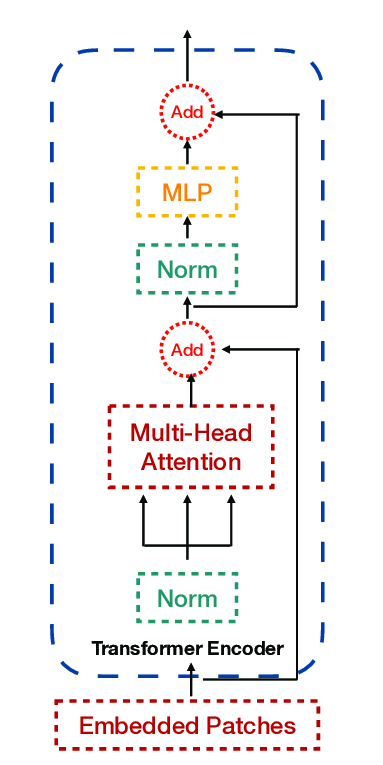


### **1. Importing Libraries**

```python
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image
```

- **`torch`**: PyTorch library, a powerful framework for deep learning.
- **`OxfordIIITPet`**: A dataset from `torchvision` that contains pet images along with their labels.
- **`matplotlib.pyplot`**: Used to visualize images from the dataset.
- **`Resize, ToTensor, to_pil_image`**: Preprocessing functions from `torchvision.transforms` for image resizing, converting to tensors, and converting back to images for visualization.

---

### **2. Preprocessing Pipeline**
```python
to_tensor = [Resize((144, 144)), ToTensor()]
```

This list includes two transformations:
1. **`Resize((144, 144))`**: Resizes all images to a fixed size of $(144 \times 144)$ pixels. This ensures uniformity for further processing.
2. **`ToTensor()`**: Converts the resized image to a PyTorch tensor.

Mathematically, this means converting an image of shape $( H \times W \times C )$ (Height, Width, Channels) into a tensor of shape $( C \times H \times W )$, where:
   - $( C )$ = number of channels (e.g., RGB has 3 channels),
   - Pixel intensities (0-255) are normalized to $([0, 1])$ using:
$$
     \text{pixel_value} = \frac{\text{pixel_intensity}}{255}
$$

---

### **3. Custom `Compose` Class**
```python
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
        return image, target
```

- **Purpose**: This is a custom implementation of the `Compose` functionality from `torchvision.transforms`. It sequentially applies the transformations in `to_tensor` to the input image.
- **`__call__`**: Makes the object callable. When called, each transformation $( t )$ in `self.transforms` is applied to the image.

---

### **4. Visualizing Images**
```python
def show_images(images, num_samples=40, cols=8):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    idx = int(len(dataset) / num_samples)
    print(images)
    for i, img in enumerate(images):
        if i % idx == 0:
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
            plt.imshow(to_pil_image(img[0]))
```

- **Parameters**:
  - `images`: The dataset or list of images to visualize.
  - `num_samples`: Number of samples to display.
  - `cols`: Number of columns in the grid layout.

- **Steps**:
  1. `plt.figure(figsize=(15,15))`: Creates a plot canvas of size $( 15 \times 15 )$.
  2. **`idx`**: Controls the spacing between samples being visualized. It's computed as:
$$
     \text{idx} = \frac{\text{length of dataset}}{\text{num_samples}}
$$
  3. Loop through the dataset, plotting one image at regular intervals controlled by `idx`.

- **`to_pil_image(img[0])`**: Converts the tensor $( C \times H \times W )$ back to a PIL image for visualization.

---

### **5. Dataset Loading**
```python
dataset = OxfordIIITPet(root=".", download=True, transforms=Compose(to_tensor))
show_images(dataset)
```

1. **Loading the dataset**:
   - **`OxfordIIITPet`**:
     - Automatically downloads the Oxford-IIIT Pet dataset if not already present.
     - Uses the `Compose(to_tensor)` transformation for preprocessing.
   - **Structure**: Each sample is a tuple:
$$
     \text{(image, target)}
$$
     - `image`: Preprocessed image tensor.
     - `target`: Label for the image (e.g., pet breed).

2. **Visualizing the dataset**:
   - Passes the dataset to `show_images()` for visualization.

---

### **Mathematical Explanation**

The core mathematical concepts in the code include:

1. **Resizing**: Adjusts the spatial dimensions of an image. For example, an image of size $( H \times W )$ is resized to $( 144 \times 144 )$.

2. **Tensor Transformation**:
   - Input Image $( H \times W \times C )$:
$$
     \text{Pixel Value} = \frac{\text{Intensity}}{255}
$$
   - Output Tensor $( C \times H \times W )$.

3. **Grid Visualization**:
   - Arranges images in a grid format with $( \text{cols} $ columns and:
$$
\text{rows} = \lceil \frac{\text{num\_samples}}{\text{cols}} \rceil
$$



## **PatchEmbedding Class**


### **1. Imports and Overview**
```python
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor
```
- **`torch.nn`**: Provides modules for building neural networks.
- **`einops.layers.torch.Rearrange`**: A utility for reshaping tensors with a simple and readable syntax.
- **`torch.Tensor`**: Defines the type annotation for tensors in PyTorch.

---

### **2. PatchEmbedding Class**
The purpose of this class is to transform an input image into a sequence of "patch embeddings" — a key step in Vision Transformers (ViTs).

#### **Constructor**
```python
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=8, emb_size=128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image into patches and flatten them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
```

- **Parameters**:
  - **`in_channels`**: Number of input channels (default: 3 for RGB images).
  - **`patch_size`**: Size of the square patch (default: $(8 \times 8)$.
  - **`emb_size`**: The size of the embedding for each patch.

- **Steps**:
  1. **Rearrange Layer**: Uses `einops` to reshape the image tensor.
     - Formula:
$$
       \text{Input shape: } (b, c, h, w) \rightarrow \text{Output shape: } (b, h \cdot w, p1 \cdot p2 \cdot c)
$$
       where:
       -$ (b)$: Batch size.
       - $(c)$: Number of input channels.
       - $(h, w)$: Height and width of the input image.
       - $(p1, p2)$: Patch height and width $(p1 = p2 = \text{patch\_size})$.

     This step divides the image into non-overlapping patches of size $(\text{patch\_size} \times \text{patch\_size})$, then flattens each patch into a 1D vector.

  2. **Linear Layer**: Projects each flattened patch to a higher-dimensional embedding space of size `emb_size`:
     - Formula:
$$       
       \mathbf{z}_i = \mathbf{W} \mathbf{x}_i + \mathbf{b}
$$       
       where:
       - $(\mathbf{x}_i)$: Flattened patch of size $(p1 \cdot p2 \cdot c)$.
       - $(\mathbf{W})$: Weight matrix of size $(\text{emb\_size}, p1 \cdot p2 \cdot c)$.
       - $(\mathbf{b})$: Bias vector of size $(\text{emb\_size}$).
       - $(\mathbf{z}_i)$: Patch embedding.

---

#### **Forward Method**
```python
def forward(self, x: Tensor) -> Tensor:
    x = self.projection(x)
    return x
```
- Applies the `projection` pipeline to the input tensor $(x)$.

---

### **3. Testing the PatchEmbedding Class**

#### Sample Input Data
```python
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
```
- **`dataset[0][0]`**: The first image in the Oxford-IIIT Pet dataset (processed as a tensor).
- **`torch.unsqueeze()`**: Adds a batch dimension to the input, making its shape:
$$
  \text{Initial shape: } (1, 3, 144, 144)
$$
  where:
  - $(1)$: Batch size.
  - $(3)$: Number of channels (RGB).
  - $(144, 144)$: Height and width of the image.

---

#### Run PatchEmbedding
```python
embedding = PatchEmbedding()(sample_datapoint)
```
- **Input Shape**: $(1, 3, 144, 144)$
- **Patch Splitting**:
  - Image size: $(144 \times 144)$.
  - Patch size: $(8 \times 8)$.
  - Number of patches per dimension:
$$
    \text{num_patches_per_dim} = \frac{\text{image_size}}{\text{patch_size}} = \frac{144}{8} = 18
$$
  - Total patches:
$$
    \text{total_patches} = \text{num_patches_per_dim}^2 = 18 \times 18 = 324
$$
- **Rearrange Output Shape**:
$$
  (1, 324, 192)
$$
  where:
  - $(324)$: Total number of patches.
  - $(192)$: Flattened size of each patch $(8 \cdot 8 \cdot 3)$.

- **Embedding Output Shape**:
$$
  (1, 324, 128)
$$
  Each patch is mapped to a 128-dimensional embedding vector.

---

#### Output
```python
print("Initial shape: ", sample_datapoint.shape)  # (1, 3, 144, 144)
print("Patches shape: ", embedding.shape)        # (1, 324, 128)
```

---

### **Summary of Functionality**
1. Splits an image into non-overlapping patches of size $( \text{patch_size} \times \text{patch_size} )$.
2. Flattens each patch into a 1D vector.
3. Projects the flattened vector to a higher-dimensional embedding space.

This is a critical step in Vision Transformers (ViT), where the image is represented as a sequence of patch embeddings for further processing.

Would you like me to explain how this integrates with Vision Transformers or provide a visualization of the patches?

## **Multi-Head Attention**:

### **1. Purpose of the `Attention` Class**
This class implements **Multi-Head Attention**, a core component of transformer architectures. Multi-Head Attention allows a model to focus on different parts of the input sequence when making predictions, and it's crucial for understanding long-range dependencies in data (e.g., sequences of words or image patches).

---

### **2. Constructor**
```python
def __init__(self, dim, n_heads, dropout):
    super().__init__()
    self.n_heads = n_heads
    self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                           num_heads=n_heads,
                                           dropout=dropout)
    self.q = torch.nn.Linear(dim, dim)
    self.k = torch.nn.Linear(dim, dim)
    self.v = torch.nn.Linear(dim, dim)
```

#### **Parameters**:
1. **`dim`**: The dimensionality of the input features (and output embeddings). For example, in Vision Transformers, this is the embedding size of each patch.
2. **`n_heads`**: The number of attention heads. Each head learns to attend to different parts of the sequence.
3. **`dropout`**: Dropout regularization applied to attention weights for preventing overfitting.

#### **Attributes**:
1. **`self.att`**:
   - Uses PyTorch's **`torch.nn.MultiheadAttention`** to compute multi-head attention.
   - Automatically handles the splitting of input into multiple heads and computes scaled dot-product attention.

2. **`self.q`, `self.k`, `self.v`**:
   - Linear layers to project the input sequence into **queries** $(Q)$, **keys** $(K)$, and **values** $(V)$.
   - Each layer maps the input $(x)$ (of shape $(\text{batch}, \text{sequence_len}, \text{dim}))$ into the same shape for further processing.

   **Formulas**:
$$
   Q = W_q x, \quad K = W_k x, \quad V = W_v x
$$   
   where:
   - $( W_q, W_k, W_v \in \mathbb{R}^{\text{dim} \times \text{dim}} )$ are the weight matrices for queries, keys, and values, respectively.

---

### **3. Forward Method**
```python
def forward(self, x):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    attn_output, attn_output_weights = self.att(q, k, v)
    return attn_output
```

#### **Input**:
- $( x )$: Input tensor of shape $(\text{batch}, \text{seq_len}, \text{dim})$, where:
  - **`batch`**: Number of sequences in the batch.
  - **`seq_len`**: Length of the sequence (e.g., number of patches in Vision Transformers).
  - **`dim`**: Dimensionality of each sequence element.

#### **Steps**:
1. **Compute Queries, Keys, and Values**:
   - $(Q = W_q x)$, $(K = W_k x)$, $(V = W_v x)$.
   - These are projections of the input \(x\) into the same dimensional space.

2. **Multi-Head Attention**:
   - The attention mechanism computes the **scaled dot-product attention**:
$$
     \text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$
     where:
     - $( Q \in \mathbb{R}^{\text{batch} \times \text{seq_len} \times \text{dim}} )$,
     - $( K, V )$ have the same dimensions as $(Q)$,
     - $( d_k )$: Dimensionality of the keys (or queries).

   - The **softmax** function normalizes the dot product $(QK^\top)$ to produce attention weights.

3. **Output**:
   - **`attn_output`**: The weighted sum of values, computed as:
$$
     \text{Output} = \sum_{i=1}^{\text{seq_len}} \alpha_{ij} V_i
$$
     where $(\alpha_{ij})$ are the attention weights (from softmax).

   - **`attn_output_weights`**: The attention weights for each head, useful for interpretability.

#### **Return**:
- Only the **attention output** (`attn_output`) is returned here, which has the shape:
$$
  (\text{batch}, \text{seq_len}, \text{dim})
$$

---

### **Mathematical Formulation**
For multi-head attention, the process is as follows:
1. Split $( Q, K, V )$ into multiple heads:
   - Each head operates on a reduced dimensionality:
$$
     \text{head_dim} = \frac{\text{dim}}{\text{n_heads}}
$$

2. Compute attention for each head:
$$
   \text{Attention}_i = \text{Softmax}\left(\frac{Q_i K_i^\top}{\sqrt{\text{head_dim}}}\right) V_i
$$

3. Concatenate the results of all heads and project back to the original dimensionality:
$$
   \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, \ldots, \text{head}_{\text{n_heads}}) W_o
$$
   where $( W_o )$ is the output projection matrix.

---

### **Key Points**
- **Multi-head attention** allows the model to focus on multiple parts of the sequence simultaneously.
- The **linear layers** for $(Q, K, V)$ ensure the flexibility of learned projections.
- PyTorch's `torch.nn.MultiheadAttention` simplifies handling multiple heads and the scaled dot-product attention.


Let's break down and explain the code, step by step:

### **PreNorm Class**:
```python
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)  # Layer Normalization for the input tensor
        self.fn = fn  # This is the function (e.g., Attention) to apply after normalization
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)  # Apply normalization first, then pass it through fn
```

#### **What is happening here?**
- **`PreNorm`** is a wrapper class designed to apply **Layer Normalization** before applying any operation (such as attention).
- **`nn.LayerNorm(dim)`** normalizes the input tensor across the feature dimension (`dim`).
  - The LayerNorm will ensure that each feature in the tensor has a mean of 0 and a variance of 1.
  
  Formula for **LayerNorm**:
  \[
  \hat{x} = \frac{x - \mu}{\sigma}
  \]
  where:
  - \( x \) is the input tensor,
  - \( \mu \) and \( \sigma \) are the mean and standard deviation across the feature dimension.

- **`self.fn`** refers to the function passed during initialization (which could be any operation, such as attention, feed-forward networks, etc.). In your case, it's an **Attention** class (explained below).
- **`forward` method**:
  - The input tensor \( x \) is passed through **LayerNorm**.
  - The output from LayerNorm is then passed through the function (`fn`), which, in this case, is the **Attention** layer.

---

### **Attention Class** (from earlier):
```python
class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(q, k, v)
        return attn_output
```

The **`Attention`** class implements a multi-head attention mechanism:
- It takes an input tensor and projects it into three components: **Queries (Q)**, **Keys (K)**, and **Values (V)**, using **Linear layers** (`self.q`, `self.k`, `self.v`).
- Then, it computes the multi-head attention using `torch.nn.MultiheadAttention`.
- **Multi-Head Attention** allows the model to attend to different parts of the input sequence simultaneously (using multiple heads).
  
---

### **Putting It All Together:**

```python
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape
```

#### **What happens here?**
1. **PreNorm** is instantiated with the following parameters:
   - `dim = 128`: The input dimensionality (i.e., the number of features for each input element).
   - `fn = Attention(dim=128, n_heads=4, dropout=0.)`: The function passed is the **Attention** layer, which takes 128-dimensional inputs, uses 4 attention heads, and has no dropout applied.

2. **Input Tensor**: `torch.ones((1, 5, 128))`
   - This is a tensor with shape `(1, 5, 128)`, where:
     - `1`: Batch size (1 sample in the batch),
     - `5`: Sequence length (5 tokens/patches),
     - `128`: Feature dimension (e.g., embedding size).

3. **Process Flow**:
   - **Step 1: Apply Layer Normalization**: The input tensor `(1, 5, 128)` is passed through the `LayerNorm` operation. Each feature in the sequence is normalized, ensuring that the mean of the features for each position in the sequence is 0, and the standard deviation is 1.
   
   - **Step 2: Apply Attention**: The normalized tensor is then passed through the `Attention` layer:
     - **Attention Layer** computes the multi-head attention. Since the tensor shape is `(1, 5, 128)`, the attention mechanism operates over a sequence of 5 elements with each element having 128 features.
     - The attention mechanism will generate an output tensor, which will have the same shape as the input `(1, 5, 128)`.

4. **Output**:
   - After applying **LayerNorm** and **Attention**, the output tensor will have the same shape as the input: `(1, 5, 128)`.
   - The tensor's feature dimension remains the same because no transformation (such as a projection) is applied to change the number of features. The multi-head attention mechanism doesn't alter the number of features, but rather computes weighted sums of values based on the attention scores.

#### **Final Output**:
```python
Output shape: torch.Size([1, 5, 128])
```

This confirms that the shape of the input tensor is preserved after passing through the **PreNorm** wrapper and the **Attention** mechanism.

---

### **Key Takeaways**:
1. **LayerNorm** normalizes the tensor before passing it to the **Attention** mechanism.
2. The **Attention** mechanism computes self-attention for the sequence, preserving the shape of the tensor.
3. The final output tensor maintains the same shape as the input, i.e., `(batch_size, seq_len, dim)`, which in this case is `(1, 5, 128)`.

Let me know if you need further clarification or have any additional questions!

## **Layer Normalization**:

#### **1. `PreNorm` Class**

```python
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)  # Layer Normalization layer
        self.fn = fn  # A function (like attention) to apply after normalization

    def forward(self, x, **kwargs):
        # Apply LayerNorm first, then pass the normalized tensor through the function `fn`
        return self.fn(self.norm(x), **kwargs)
```

- **`PreNorm`** is a wrapper that applies **Layer Normalization** to the input tensor before passing it to another function, such as **Attention**.
  - **Layer Normalization** stabilizes training by normalizing the activations of the model for each feature across the batch.
  - **`fn`** represents any function or operation to be applied after normalization, which, in your case, is **Attention**.

#### **2. `Attention` Class**

```python
class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        # Compute queries, keys, and values
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        # Perform multi-head attention
        attn_output, attn_output_weights = self.att(q, k, v)
        return attn_output
```

- **`Attention`** implements the **Multihead Self-Attention** mechanism:
  - It projects the input tensor into three components: **Queries (Q)**, **Keys (K)**, and **Values (V)**.
  - These components are then passed to the **Multihead Attention** layer (`torch.nn.MultiheadAttention`), which computes the attention weights and generates the output based on those weights.
  - The output of the attention layer is returned, which is a weighted sum of the values according to the attention scores.

#### **3. The Combination:**
```python
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape
```

- You’re creating an instance of `PreNorm`, passing the **`Attention`** layer as `fn`.
  - **`dim=128`**: The feature dimension of your input.
  - **`n_heads=4`**: The number of attention heads (this means the attention mechanism will learn 4 different attention patterns).
  - **`dropout=0.`**: No dropout is applied (this is the probability that some units will be dropped out to prevent overfitting).

- You then call the `norm` object with an input tensor of shape `(1, 5, 128)`, which corresponds to:
  - **Batch size** = 1
  - **Sequence length** = 5 (the number of tokens or patches in the input sequence)
  - **Feature dimension** = 128 (the number of features for each token/patch)

- After **Layer Normalization** is applied to the input tensor (shape: `(1, 5, 128)`), the **`Attention`** layer computes the multi-head attention and returns the output of the same shape.

### **What Happens in This Code?**
1. **Input Tensor**: A tensor of shape `(1, 5, 128)` is passed into the `norm` layer.
2. **Layer Normalization**: The input tensor is normalized along the feature dimension (`128`).
3. **Multihead Attention**:
   - The normalized tensor is processed by the **Attention** mechanism.
   - **Queries (Q)**, **Keys (K)**, and **Values (V)** are computed using linear projections.
   - The attention mechanism uses these to compute the output based on the attention scores.
4. **Output**: The output tensor has the same shape as the input: `(1, 5, 128)`.

### **Why LayerNorm before Attention?**
- **Layer Normalization** is typically applied before each block in transformer architectures like the Vision Transformer (ViT) because it helps stabilize training by normalizing the activations.
- Applying normalization before the attention mechanism allows the model to focus on learning better attention scores rather than being influenced by the scale of input features.
  
### **Shape of the Output:**
The output shape of the tensor after passing through **PreNorm** and **Attention** will be `(1, 5, 128)` (the same as the input).

### **Final Explanation**:
You added a normalized attention mechanism in the code snippet. This piece of code is a **small part** of the Vision Transformer architecture, where the input is passed through **Layer Normalization**, then through the **Attention** layer (multi-head self-attention), and the final output has the same shape as the input.


## **FeedForward**:

### **`FeedForward` Class**

```python
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),  # First linear transformation
            nn.GELU(),                   # GELU activation function
            nn.Dropout(dropout),         # Dropout to prevent overfitting
            nn.Linear(hidden_dim, dim),  # Second linear transformation
            nn.Dropout(dropout)          # Dropout after second linear layer
        )
```

- **`FeedForward`** is a class that represents a **feed-forward neural network** used in many transformer models, including Vision Transformers (ViT).
- It is implemented as a subclass of **`nn.Sequential`**, which means that the layers are applied in a sequence without needing to explicitly define a `forward` method.
  
### **Layers in the FeedForward Block:**
1. **`nn.Linear(dim, hidden_dim)`**:
   - This is the first **fully connected (linear) layer** that transforms the input tensor from the original feature dimension (`dim = 128`) to a higher-dimensional space (`hidden_dim = 256`).
   - This operation performs a matrix multiplication followed by a bias addition.

2. **`nn.GELU()`**:
   - **GELU (Gaussian Error Linear Unit)** is the activation function applied after the first linear layer. It is a smoother alternative to the ReLU activation and is used in transformer models.
   - The GELU activation function is defined as:
$$
     \text{GELU}(x) = 0.5x \left( 1 + \tanh \left( \sqrt{\frac{2}{\pi}} \cdot \left( x + 0.044715 x^3 \right) \right) \right)
$$

3. **`nn.Dropout(dropout)`**:
   - Dropout is applied after the activation function and after the second linear layer to regularize the model and prevent overfitting. It randomly drops units (with probability `dropout`) during training.

4. **`nn.Linear(hidden_dim, dim)`**:
   - This is the second **fully connected layer** that maps the tensor back to the original feature dimension (`dim = 128`).

5. **`nn.Dropout(dropout)`**:
   - Dropout is applied again after the second linear layer to ensure regularization.

### **Code to Test the FeedForward Class**:
```python
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape
```

- **Input Tensor**: `torch.ones((1, 5, 128))`
  - This is a tensor of shape `(1, 5, 128)`, which means:
    - `1` is the batch size (1 sample),
    - `5` is the sequence length (5 tokens/patches),
    - `128` is the feature dimension (input dimension for each token/patch).
  
- **Process**:
  - The input tensor is passed through the **FeedForward** block.
  - The first linear layer increases the feature dimension from `128` to `256`.
  - Then, GELU activation and dropout are applied.
  - After that, the second linear layer reduces the feature dimension back to `128`.
  - Dropout is applied again after the second linear layer.

### **Expected Output Shape**:
- Since the **`FeedForward`** block operates on a per-token basis, the output will have the same sequence length (`5` tokens/patches) and the same batch size (`1`).
- The feature dimension is mapped from `128` → `256` → `128`, but the sequence length and batch size are unchanged.

So, the **output shape** will be `(1, 5, 128)`.

### **Output**:
```python
torch.Size([1, 5, 128])
```

### **Summary**:
- The **FeedForward** block increases the feature dimension and applies a nonlinear activation (GELU) before returning to the original dimension.
- The output shape remains the same as the input shape `(1, 5, 128)`, as the feed-forward network operates independently on each token/patch.


## **residual connections**:

The **`ResidualAdd`** class you've provided is a key component of transformer architectures, where **residual connections** (also known as skip connections) are commonly used to improve training stability and facilitate the flow of gradients.

### **`ResidualAdd` Class Explained:**

```python
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn  # Function to apply (e.g., Attention or FeedForward)

    def forward(self, x, **kwargs):
        res = x  # Store the original input tensor (residual)
        x = self.fn(x, **kwargs)  # Apply the function (like Attention or FeedForward)
        x += res  # Add the residual to the output
        return x  # Return the output with the residual added
```

### **How the `ResidualAdd` Class Works:**

1. **Initialization**:
   - The class takes a function `fn` as input, which represents a layer or operation that you want to apply to the input tensor. In the context of transformers, `fn` could be an attention layer, a feed-forward network, etc.

2. **Forward Pass**:
   - **`res = x`**: The original input tensor `x` is saved as the residual (`res`).
   - **`x = self.fn(x, **kwargs)`**: The function `fn` (like Attention or FeedForward) is applied to the input tensor `x`.
   - **`x += res`**: The original input tensor `res` is added back to the output of the function. This is the **residual connection**, and it helps prevent the network from vanishing gradients and allows it to train more efficiently.
   - **`return x`**: The final output tensor is returned, which is the sum of the transformed tensor and the original input (residual connection).

### **Why Use Residual Connections?**

- **Improved Gradient Flow**: Residual connections allow gradients to flow directly through the network during backpropagation, making it easier to train deep networks.
- **Avoid Vanishing Gradients**: By adding the input back to the output, the model can maintain a direct path for gradients to propagate through, which helps mitigate the vanishing gradient problem in deep networks.
- **Faster Convergence**: With residual connections, the model is more likely to converge faster during training because it can learn better representations by utilizing both the original input and the transformed features.

### **Example Use in Transformer Networks**:

In transformer models, **residual connections** are commonly added after each layer (e.g., after the attention mechanism and the feed-forward layers). For instance, you might apply **ResidualAdd** around the Attention block and FeedForward block to help with better training.

### **Example of Applying `ResidualAdd`:**

```python
# Assume we have a ResidualAdd instance wrapping around the Attention and FeedForward blocks
residual_attention = ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.))
residual_ff = ResidualAdd(FeedForward(dim=128, hidden_dim=256))

# Now, we can use them in a transformer block like this:
x = torch.ones((1, 5, 128))  # Input tensor with shape (batch, sequence, feature)
x = residual_attention(x)    # Apply attention with residual connection
x = residual_ff(x)           # Apply feed-forward with residual connection
```

In this example, the input `x` goes through **Attention** and **FeedForward** layers, but with residual connections that add the original `x` back to the outputs.

### **Summary:**
- **`ResidualAdd`** is a module that wraps around any function or operation and adds the input tensor back to the output of the operation.
- This is a **residual connection**, which helps improve gradient flow, prevent vanishing gradients, and speeds up the convergence of deep networks like transformers.
- It's commonly used in transformer blocks after operations like **attention** and **feed-forward networks**.

## **Vision Transformer ViT**:


The code you provided is the implementation of a **Vision Transformer (ViT)** model in PyTorch. Let's break down the components of the `ViT` class and explain how each part contributes to the overall transformer architecture.

### **`ViT` Class Explanation**

The **Vision Transformer (ViT)** is a transformer model designed to process images by treating them as sequences of image patches. It relies on transformer architecture components such as attention mechanisms and feed-forward networks to process and classify images.

Here is the breakdown of the components in your ViT implementation:

### **1. Constructor: `__init__`**

```python
def __init__(self, ch=3, img_size=144, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=37, dropout=0.1, heads=2):
```

- **`ch`**: The number of input channels of the image (3 for RGB images).
- **`img_size`**: The height and width of the input image (144x144 in this case).
- **`patch_size`**: The size of the patches the image is divided into (4x4 patches).
- **`emb_dim`**: The embedding dimension for the image patches (32 in this case).
- **`n_layers`**: The number of transformer layers (6 layers in this example).
- **`out_dim`**: The number of output classes for classification (37 in this case).
- **`dropout`**: The dropout rate for regularization (0.1 in this case).
- **`heads`**: The number of attention heads in the multi-head attention mechanism (2 heads here).

### **2. Patching and Patch Embedding:**

```python
self.patch_embedding = PatchEmbedding(in_channels=ch, patch_size=patch_size, emb_size=emb_dim)
```

- **`PatchEmbedding`**: This layer splits the image into non-overlapping patches and then projects each patch into an embedding space of size `emb_dim` (32). Each patch is treated as a "token" in the transformer model.

```python
num_patches = (img_size // patch_size) ** 2
self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))
self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))
```

- **Position Embedding**: Since transformers are not inherently aware of the spatial structure of images, a position embedding is added to each patch to maintain positional information. The position embedding is learnable, and its size matches the number of patches.
- **Class Token**: The **class token (`cls_token`)** is added to the sequence of patches. This token will aggregate information from all patches and be used for final classification. It’s initialized randomly as a learnable parameter.

### **3. Transformer Encoder:**

```python
self.layers = nn.ModuleList([])
for _ in range(n_layers):
    transformer_block = nn.Sequential(
        ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
        ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
    self.layers.append(transformer_block)
```

- **Transformer Layers**: These layers consist of **multi-head self-attention** followed by **feed-forward networks**. Each transformer block contains two main components:
  - **Attention Mechanism**: The `Attention` block applies multi-head self-attention, which allows the model to focus on different parts of the image (or patches) simultaneously.
  - **Feed-Forward Network**: After the attention block, a position-wise feed-forward network is applied to each token independently.
  - **Residual Connections**: Each component (attention and feed-forward) has a residual connection using the `ResidualAdd` class to help with gradient flow during training.

### **4. Classification Head:**

```python
self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))
```

- **Classification Head**: After the transformer layers, the output corresponding to the **class token** (`x[:, 0, :]`) is passed through a layer normalization and a final linear layer to produce the output logits for classification.

### **5. Forward Pass:**

```python
def forward(self, img):
    # Get patch embedding vectors
    x = self.patch_embedding(img)
    b, n, _ = x.shape

    # Add cls token to inputs
    cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
    x = torch.cat([cls_tokens, x], dim=1)
    x += self.pos_embedding[:, :(n + 1)]

    # Transformer layers
    for i in range(self.n_layers):
        x = self.layers[i](x)

    # Output based on classification token
    return self.head(x[:, 0, :])
```

- **Patch Embedding**: The input image is passed through the `PatchEmbedding` layer, which converts it into patches and maps them to the embedding space.
- **Class Token**: A class token is prepended to the sequence of patches, and the position embeddings are added to the sequence.
- **Transformer Layers**: The sequence (patches + class token) goes through multiple transformer layers, where each layer applies attention and feed-forward transformations.
- **Classification**: After all transformer layers, the output corresponding to the **class token** is passed through a final linear layer to get the classification logits.

### **6. Model Instantiation and Testing:**

```python
model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))
```

- This initializes the ViT model with a `144x144` input image of 3 channels (RGB).
- A dummy input of shape `(1, 3, 144, 144)` is passed to the model to test the forward pass.

### **Summary of ViT:**
- The model processes images by dividing them into patches, which are treated as tokens for the transformer.
- It uses **multi-head self-attention** to capture long-range dependencies between patches, followed by **feed-forward networks** to process the features.
- A **class token** is used for classification, and the final prediction is made based on the output of this token.

This architecture leverages the power of transformers to process images, which has proven to be effective for various vision tasks. Let me know if you need further clarification on any part of the model!

### **Training loop for the *Vision Transformer (ViT)*:**

Your code sets up the training loop for the **Vision Transformer (ViT)** model and evaluates its performance using the test data. Let's go through each part of the process to explain how it works.

### **1. Splitting the Dataset:**

```python
train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])
```

- You are dividing the dataset into **training** and **test** sets using an 80/20 split.
- `random_split` randomly splits the dataset according to the given proportions. Here, 80% of the dataset goes to the `train` set, and 20% goes to the `test` set.

### **2. DataLoaders:**

```python
train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)
```

- **DataLoader** is used to load the data in batches.
  - `batch_size=32`: Each batch contains 32 images and their corresponding labels.
  - `shuffle=True`: Randomly shuffles the dataset before each epoch to avoid any bias due to the order of the data.

### **3. Setup Model, Optimizer, and Loss Function:**

```python
device = "cuda"
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
```

- **`device = "cuda"`**: This moves the model to the GPU for faster computation if CUDA is available.
- **Model**: The ViT model is instantiated and moved to the GPU.
- **Optimizer**: `AdamW` optimizer is used with a learning rate of `0.001`. It is a variant of the Adam optimizer with weight decay.
- **Loss Function**: `CrossEntropyLoss` is used, which is standard for multi-class classification tasks. It computes the loss between the predicted class probabilities and the true labels.

### **4. Training Loop:**

```python
for epoch in range(1000):
    epoch_losses = []
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
```

- **Epoch Loop**: You run for 1000 epochs (which might be excessive for this model depending on your dataset and task).
- **Train Mode**: `model.train()` sets the model in training mode (useful if you have layers like dropout, which behave differently in training and evaluation modes).
- **Data Loop**: For each batch, you:
  - Move the inputs and labels to the GPU.
  - Set the gradients to zero (`optimizer.zero_grad()`).
  - Pass the inputs through the model (`model(inputs)`).
  - Compute the loss using `CrossEntropyLoss` (`loss = criterion(outputs, labels)`).
  - Perform backpropagation (`loss.backward()`).
  - Update the model parameters (`optimizer.step()`).
- The loss for each batch is appended to `epoch_losses`, and the average loss for the epoch will be printed every 5 epochs.

### **5. Evaluation on the Test Set:**

```python
if epoch % 5 == 0:
    print(f">>> Epoch {epoch} train loss: ", np.mean(epoch_losses))
    epoch_losses = []
    # Something was strange when using this?
    # model.eval()
    for step, (inputs, labels) in enumerate(test_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        epoch_losses.append(loss.item())
    print(f">>> Epoch {epoch} test loss: ", np.mean(epoch_losses))
```

- **Every 5 epochs**, you print the average **train loss** for the current epoch.
- Then, you switch the model to **evaluation mode** (`model.eval()`), although this line is commented out. **Evaluation mode** ensures that layers like dropout and batch normalization behave correctly during inference.
- After that, you evaluate the model on the **test set** by passing it through the test `DataLoader`. You compute and print the **test loss** for each batch.

### **6. Final Evaluation on Test Set:**

```python
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)

print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)
```

- This part evaluates the model on a single batch from the test set:
  - **`inputs, labels = next(iter(test_dataloader))`** gets the first batch from the `test_dataloader`.
  - The `inputs` and `labels` are moved to the GPU.
  - The model's predictions are obtained by passing the inputs through the model (`outputs = model(inputs)`).
  - **Predicted classes** are obtained by taking the `argmax` of the model's output (which gives the index of the highest predicted probability for each sample).
  - The **actual classes** are printed to compare the model's predictions to the ground truth.

### **Key Notes:**
- **Model.eval()**: You should use this mode during evaluation to ensure that layers like dropout or batch normalization are handled properly. It is commented out in the code, but it’s important to call it before running any inference.
- **Epoch Count**: 1000 epochs might be too many for this type of task. It’s usually a good idea to monitor the loss during training and stop early if the loss stabilizes.

### **Possible Improvements:**
1. **Learning Rate Scheduling**: You might want to use a learning rate scheduler to adjust the learning rate over time, improving convergence.
2. **Early Stopping**: Implement early stopping to stop training when the validation or test loss stops improving.
3. **Model.eval()**: Don’t forget to call `model.eval()` during inference or validation to ensure the model behaves correctly.



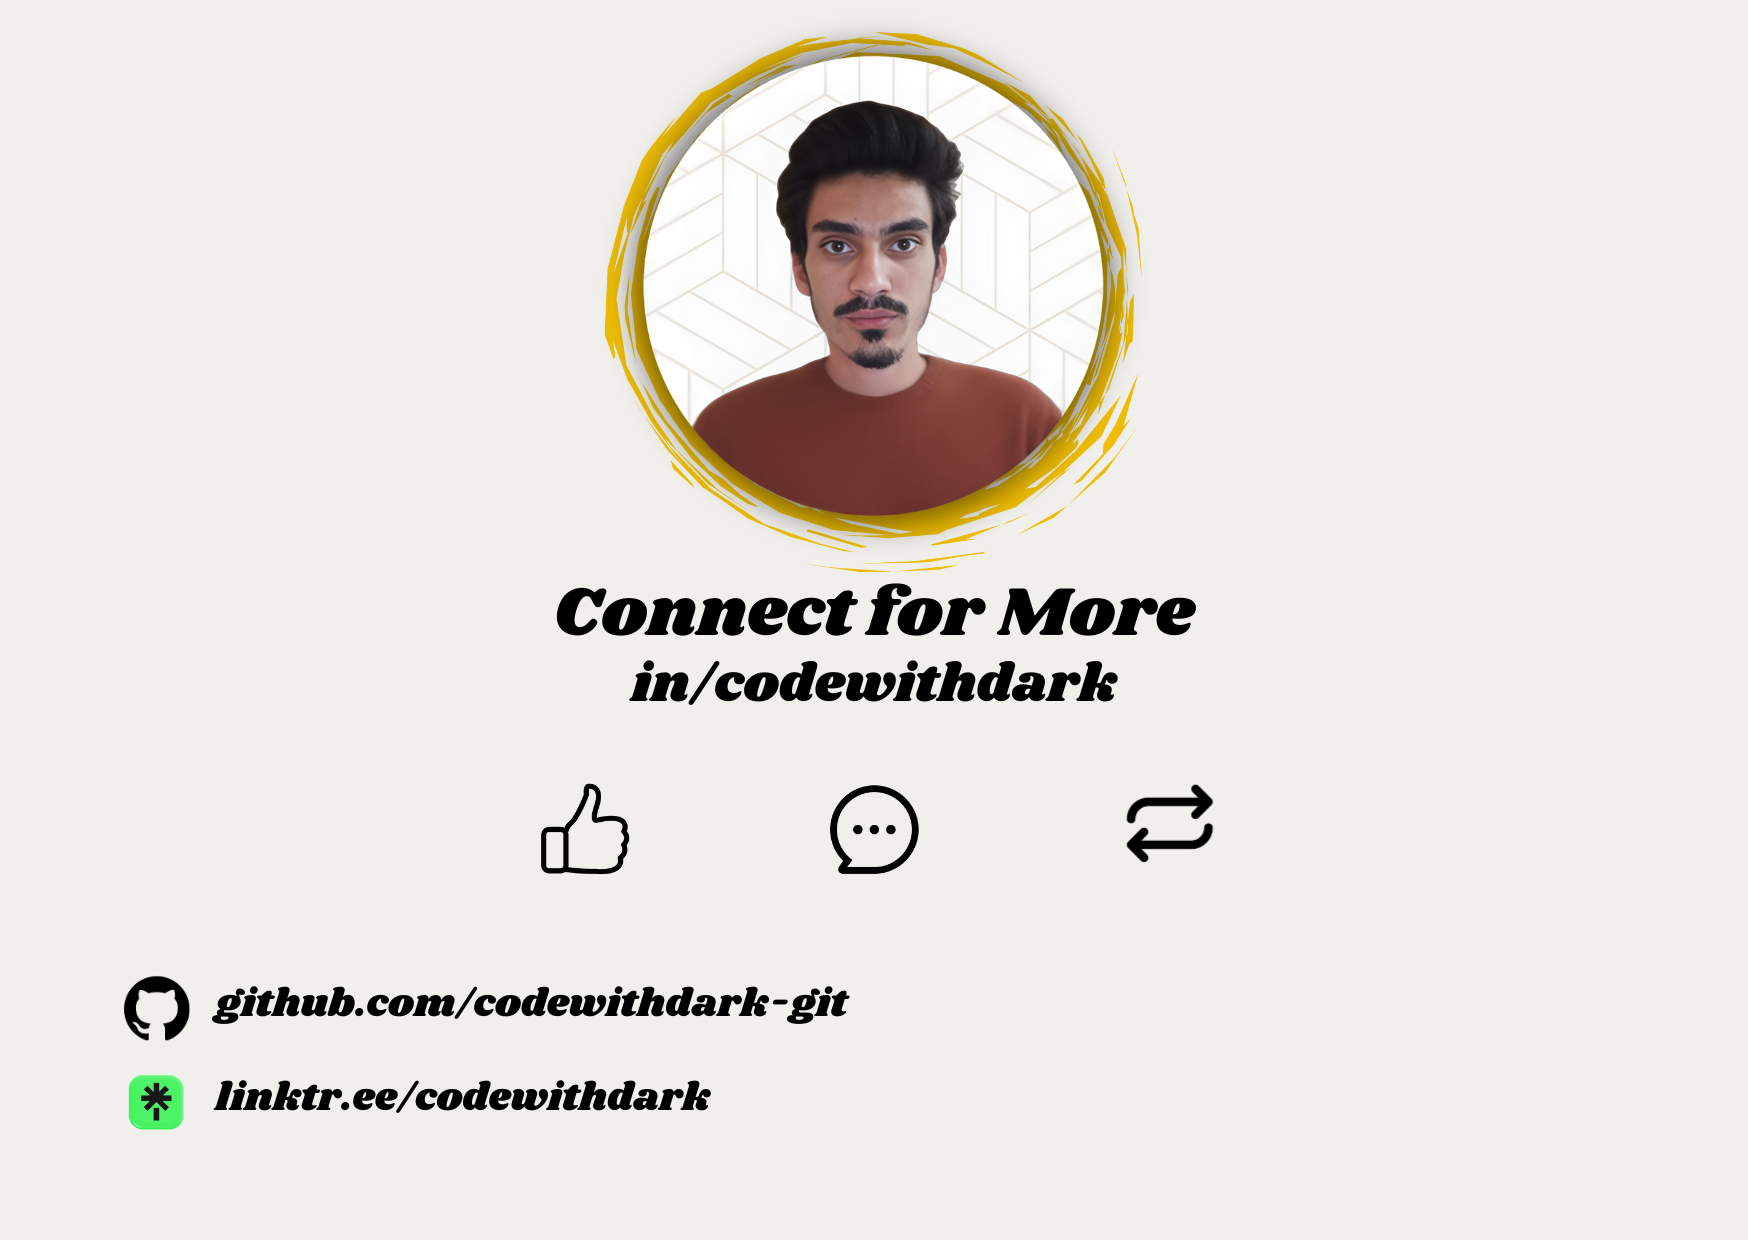